# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [1]:
#Import Packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')
import yfinance as yf
import numpy.random as npr
import math
import seaborn as sns
npr.seed(42)

In [2]:
# required functions
def calculate_var_95(portfolio_returns):
    """
    # Function developed by Thomas Polstra
    Calculate the Value at Risk (VaR) at the 95% confidence interval for a given portfolio.

    Parameters:
    portfolio_returns (numpy array): An array of portfolio returns.

    Returns:
    float: The VaR at the 95% confidence level expressed as a percentage.
    """
    # Sort the portfolio returns in ascending order
    sorted_returns = np.sort(portfolio_returns)

    # Determine the number of data points
    N = len(sorted_returns)

    # Calculate the index corresponding to the 5th percentile (95% confidence level)
    percentile_index = int(0.05 * N)

    # Find the return value at the 5th percentile
    var_95 = sorted_returns[percentile_index]

    # Express VaR as a percentage by multiplying it by 100
    var_95_percent = var_95 * 100

    return var_95_percent

def portfolio_variance(weights, covariance_matrix):
    """
    Calculate the variance of a given portfolio.
    
    Parameters: 
    covariance_matrix (numpy array): An array of the covariance matrix

    Returns:
    float: The variance computed
    """
    sigma_V_2 = np.matmul(np.array(np.matmul(weights, covariance_matrix)), weights[:, np.newaxis]) 
    return np.squeeze(sigma_V_2)

def portfolio_expected_return(weights, daily_returns, tickers):
    m = np.array([daily_returns[stock].mean() for stock in tickers])
    m_V = np.matmul(m*252, weights[:, np.newaxis])
    return np.squeeze(m_V) 

def returns(daily_returns, tickers, weights):
    asset_returns_array = np.array([daily_returns[stock] for stock in tickers])
    optimal_weights_transposed = weights[:, np.newaxis]
    portfolio_returns = np.sum(asset_returns_array*optimal_weights_transposed, axis = 0)
    return portfolio_returns

def sharpe_ratio(mu_v, sigma_v, risk_free_rate):
    return ((mu_v - risk_free_rate)/sigma_v)

# Solution

For this project, 8 candidate companies have been initially selected taking into account diversity among the different economical sectors.

Analyses were performed over a time span of two years for two cases: (Case A) portfolio with the minimal variance, and (Case B) portfolio with the criteria of the higher Sharpe ratio.

The calculations are based on the following definitions:

* Expected return:

  $$\mu_V = \mathbf{m} \mathbf{w}^T$$
  
  
* Volatility:
  $$\sigma_V = \sqrt{\mathbf{w}\mathbf{C}\mathbf{w}^{T}}$$

* Sharpe ratio:
  $$S_r = \frac{\mu_V - r}{\sigma_V}$$


  where

  $$\mathbf{w} = [w_1, w_2, \cdots, w_N]$$ 

  $$\mathbf{m} = [\mu_1, \mu_2, \cdots, \mu_N]$$

  $$\mathbf{u} = [1, 1, \cdots, 1]$$

  $$\mathbf{C} = \begin{bmatrix}
c_{11}&c_{12} & \cdots & c_{1N} \\
c_{21}&c_{22} & \cdots & c_{2N} \\
\vdots & \vdots & \ddots & \vdots \\
c_{N1}&c_{N2} & \cdots & c_{NN}
\end{bmatrix} $$

$$c_{ij} = Cov(K_i, K_j)$$

$\mathbf{w}$ (portfolio weights vector)

$\mathbf{m}$ (expected return assets vector)

$K_i$ (return value for the asset $i$)

$r$ (Risk free rate)

## Part 1: Download stocks data and data exploration

In [3]:
names_companies = ['Fast Retailing Co., Ltd.','Alphabet Inc.','International Business Machines Corporation','JPMorgan Chase & Co.','Netflix, Inc.','Novartis AG','Exxon Mobil Corporation','Yum! Brands, Inc.' ]
tickers = ['FRCOY', 'GOOG', 'IBM', 'JPM', 'NFLX', 'NVS', 'XOM', 'YUM']

start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

stock = yf.download(tickers, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed


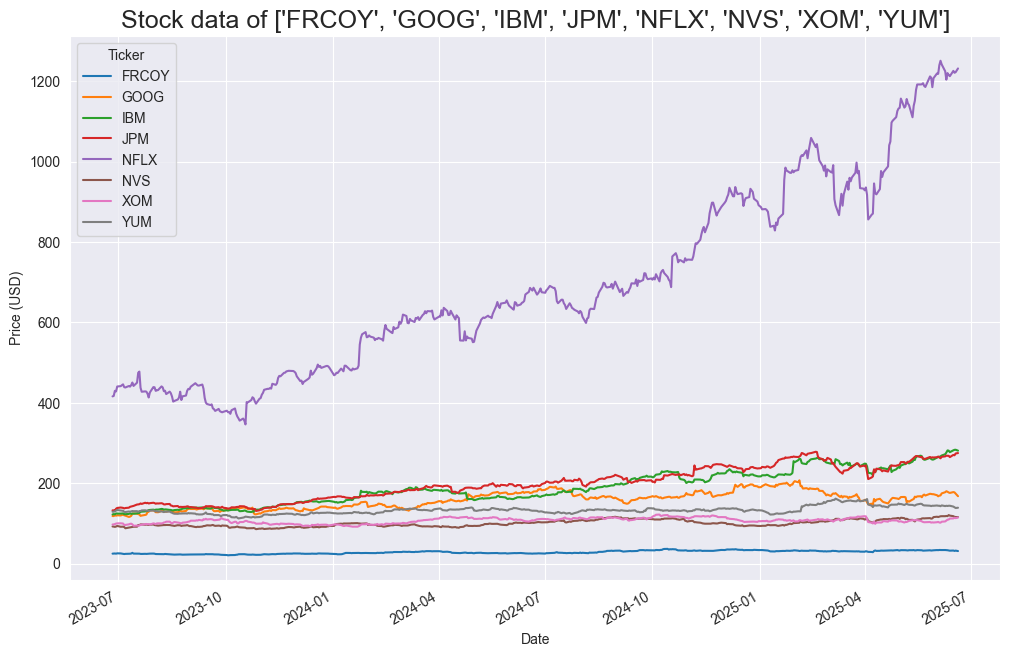

In [4]:
#Plot Closing Price stock data
stock['Close'][tickers].plot(figsize = (12,8))
plt.title(f'Stock data of {tickers}', size = 18)
plt.ylabel('Price (USD)')
plt.show()

In [5]:
#Add in column that is cumulative returns of the stocks

# Step 1: Compute cumulative return from 'Close' prices
close = stock['Close']
normalized_returns = close/close.iloc[0]-1

# Step 2: Create MultiIndex columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )

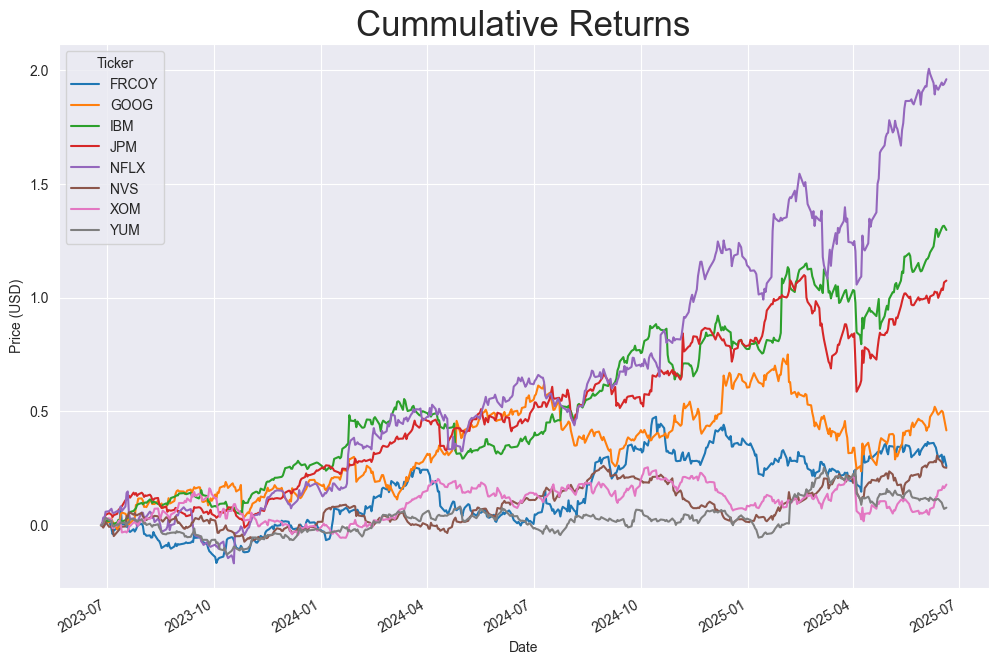

In [6]:
#Plot Cumlative Returns together
stock['Cumulative Return'][tickers].plot(figsize = (12,8))
plt.title(f'Cummulative Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

First, let us calculate the daily returns for all the candidate companies. 

In [7]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
log_daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
log_daily_returns = log_daily_returns.dropna()

The expected log return (anualized) for the individual portfolio assets is

In [8]:
log_daily_returns.mean()*252

Ticker
FRCOY    0.116441
GOOG     0.176300
IBM      0.420993
JPM      0.369407
NFLX     0.549225
NVS      0.113852
XOM      0.083002
YUM      0.037474
dtype: float64

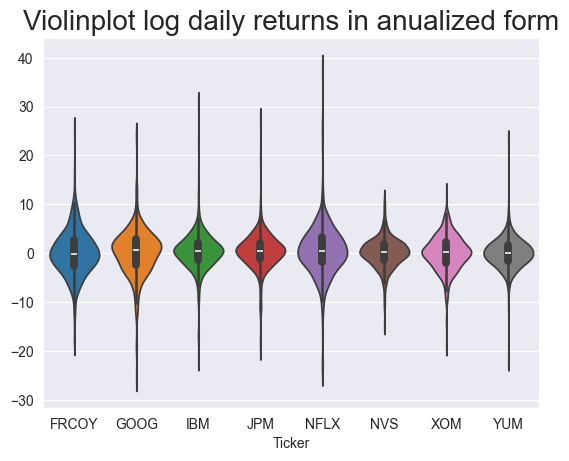

In [9]:
sns.violinplot( data=log_daily_returns*252, order=tickers)
plt.title('Violinplot log daily returns in anualized form', size=20)
plt.show()

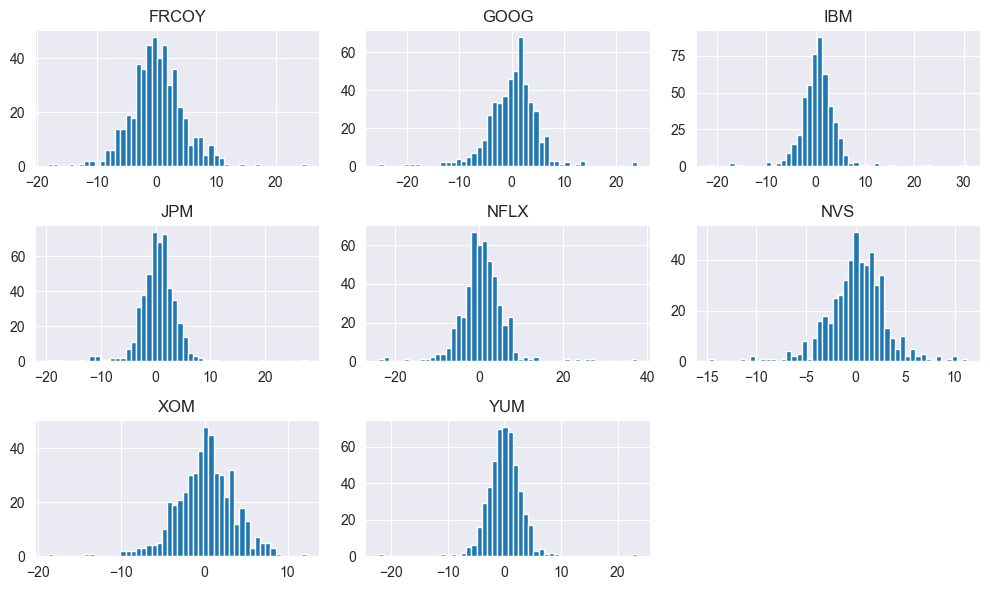

In [10]:
(log_daily_returns*252).hist(figsize=(10,6), bins=50)
plt.tight_layout()

After this, I will utilize the Pearson coefficient to explore possible correlations between assets. The pearson coefficient is defined as $$\rho_{XY}= E((X - \mu_X)(Y-\mu_Y))/(\sigma_X \sigma_Y)$$

In [11]:
#nc = len(symbols_list)
nc = len(tickers)
rho = np.zeros([nc, nc])
for i in range(nc):
    for j in range(nc):
        muX = np.mean(log_daily_returns.iloc[:,j])
        muY = np.mean(log_daily_returns.iloc[:,i])
        sigmaX = np.std(log_daily_returns.iloc[:,j])
        sigmaY = np.std(log_daily_returns.iloc[:,i])

        rho[j,i] = np.mean( (log_daily_returns.iloc[:,j] - muX)*(log_daily_returns.iloc[:,i] - muY) )/(sigmaX*sigmaY)

rho =  pd.DataFrame(data = rho, columns = tickers, index = tickers )


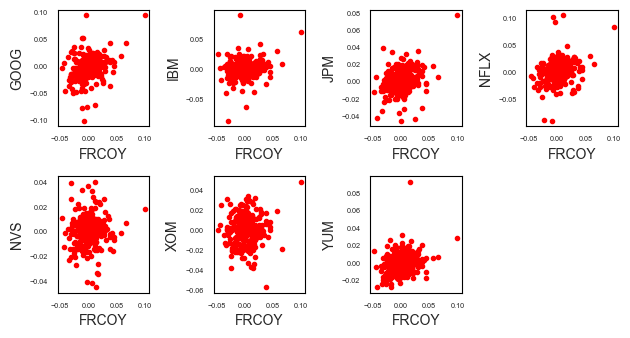

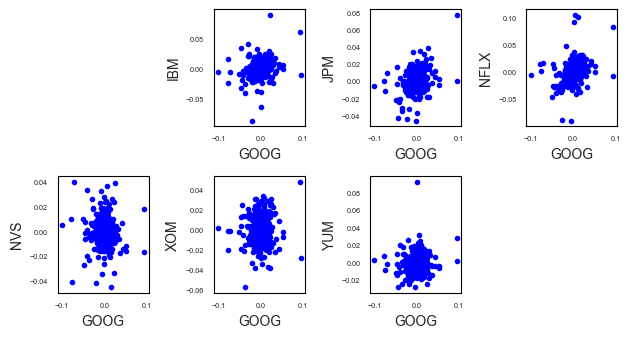

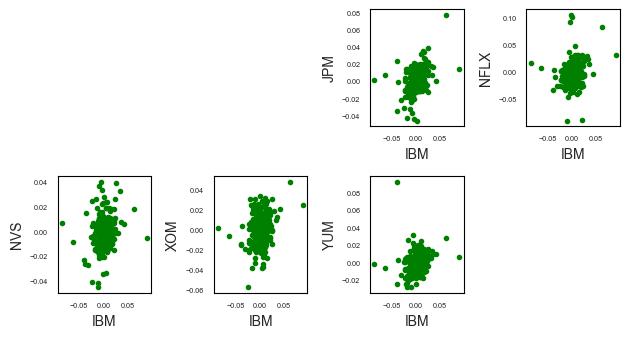

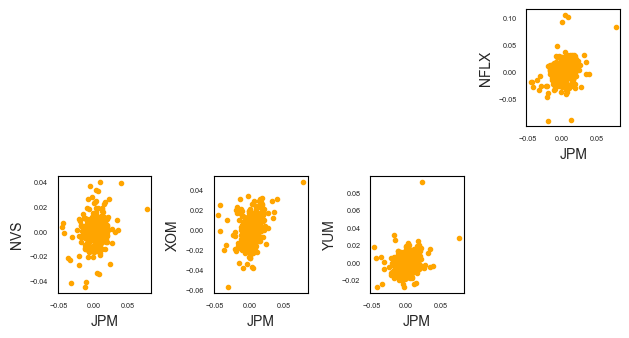

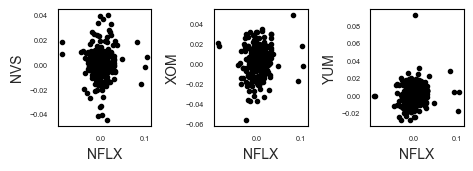

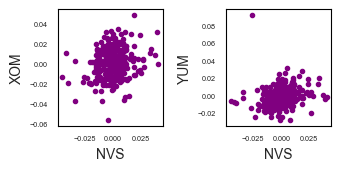

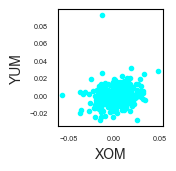

<Figure size 640x480 with 0 Axes>

In [12]:
points = np.random.choice(len(log_daily_returns.iloc[:,0]), 300, replace=False)

nco = 4
nr = 3
color = ['red','blue','green','orange','black','purple','cyan','pink','grey','magenta','red']
#nco=2
#nr=3
for i in range(nc):
    plt.figure()
    for j in range(nc):
        if j>i:
            plt.subplot(nr, nco, j) # (rows, columns, panel number)
            plt.plot(log_daily_returns.iloc[points,i],log_daily_returns.iloc[points,j],'.',color = color[i])
            plt.xlabel(tickers[i])
            plt.ylabel(tickers[j])
            plt.grid(False)
            ax = plt.gca()  
            ax.set_facecolor("white")
            ax.spines[:].set_color("black")
            ax.tick_params(axis = 'both', which = 'major', labelsize = 5.3)
            ax.tick_params(axis = 'both', which = 'minor', labelsize = 5.3)
    
    plt.tight_layout()

In [13]:
print('Correlations between companies log daily returns (Pearson coefficient):')
rho

Correlations between companies log daily returns (Pearson coefficient):


,FRCOY,GOOG,IBM,JPM,NFLX,NVS,XOM,YUM
FRCOY,1.000000,0.285562,0.244854,0.277569,0.252184,0.084499,0.129569,0.242350
GOOG,0.285562,1.000000,0.213631,0.277973,0.329217,-0.025203,0.060589,0.132716
IBM,0.244854,0.213631,1.000000,0.347349,0.175504,0.219653,0.243272,0.233829
JPM,0.277569,0.277973,0.347349,1.000000,0.233262,0.172483,0.383212,0.227698
NFLX,0.252184,0.329217,0.175504,0.233262,1.000000,0.038584,0.091228,0.131630
NVS,0.084499,-0.025203,0.219653,0.172483,0.038584,1.000000,0.220243,0.274600
XOM,0.129569,0.060589,0.243272,0.383212,0.091228,0.220243,1.000000,0.219645
YUM,0.242350,0.132716,0.233829,0.227698,0.131630,0.274600,0.219645,1.000000


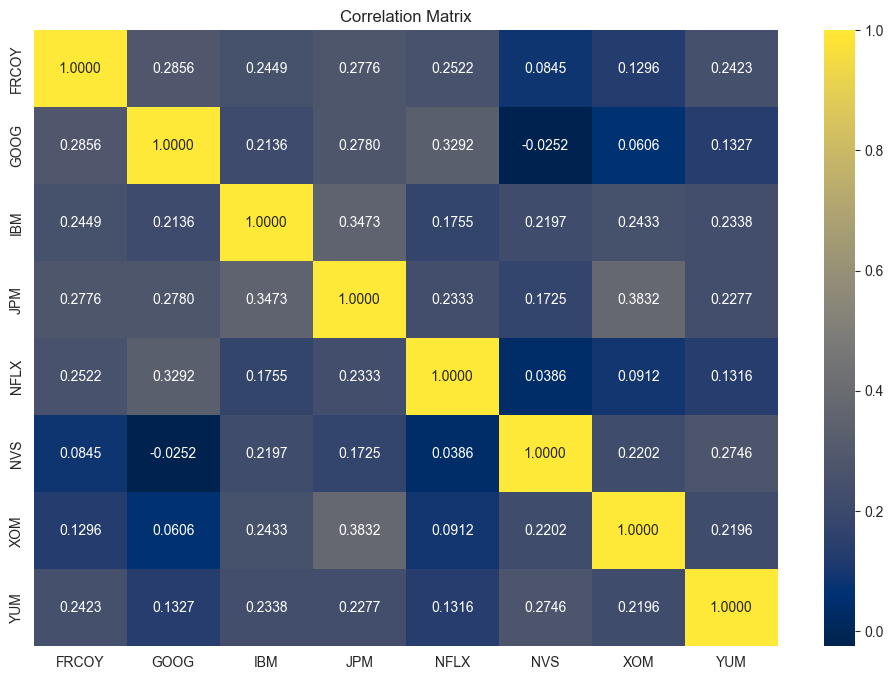

In [14]:
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize = (12,8))
sns.heatmap(rho, annot = True, cmap = 'cividis', fmt ='.4f')
plt.title('Correlation Matrix')
plt.show()

The plot below shows the corresponding covariance matrix for the log daily returns.

In [15]:
# Calculate the covariance matrix
covariance_matrix = 252*((log_daily_returns).cov())
print('Covariance matrix log daily returns')

covariance_matrix

Covariance matrix log daily returns


Ticker,FRCOY,GOOG,IBM,JPM,NFLX,NVS,XOM,YUM
Ticker,,,,,,,,
FRCOY,0.082286,0.024384,0.017064,0.018604,0.024064,0.004547,0.008317,0.013232
GOOG,0.024384,0.088608,0.015449,0.019334,0.032599,-0.001407,0.004036,0.007519
IBM,0.017064,0.015449,0.059021,0.019717,0.014183,0.010011,0.013225,0.010812
JPM,0.018604,0.019334,0.019717,0.054595,0.018130,0.007561,0.020036,0.010126
NFLX,0.024064,0.032599,0.014183,0.018130,0.110654,0.002408,0.006791,0.008334
NVS,0.004547,-0.001407,0.010011,0.007561,0.002408,0.035193,0.009245,0.009805
XOM,0.008317,0.004036,0.013225,0.020036,0.006791,0.009245,0.050071,0.009355
YUM,0.013232,0.007519,0.010812,0.010126,0.008334,0.009805,0.009355,0.036226


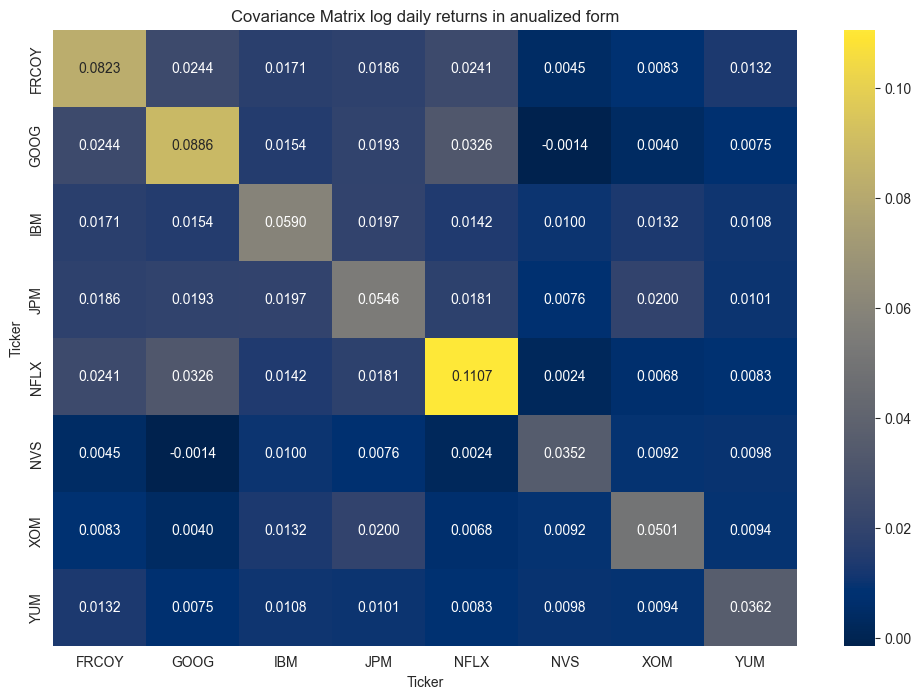

In [16]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot = True, cmap = 'cividis', fmt ='.4f')
plt.title('Covariance Matrix log daily returns in anualized form')
plt.show()

From the plots and the correlation coefficient matrix is possible to conclude that the candidate companies are not strongly correlated. The most significative positive correlation corresponds to JPM and GOOG ($\rho = 0.3828$). For this reason all the candidate companies exhibit diversification, and are suitable to be included in the portfolio.

## Part 2a Lower risk: Portfolio optimization under the criteria of minimizing the portfolio variance

In order to create a portfolio with the lowest risk, we will proceed to find the set $\mathbf{w}$ of asset weights which minimizes the historical portfolio's variance subject to the following constrains:

1. $\sum_i^N w_i = 1$
2. Cannot invest more that 35% of capital into a single asset, this is $w_i < 0.35$.


In [17]:
n_assets = len(tickers)

initial_weights = np.array([1/n_assets] * n_assets)

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_v(weights):
    portfolio_var = portfolio_variance(weights, covariance_matrix)
    return portfolio_var

result = minimize(portfolio_v, initial_weights, constraints = constraints)

optimal_weights = result.x

print("Optimal Asset Weights to minimize variance:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize variance:
FRCOY: Weight = 0.0513
GOOG: Weight = 0.0993
IBM: Weight = 0.0678
JPM: Weight = 0.0532
NFLX: Weight = 0.0513
NVS: Weight = 0.2997
XOM: Weight = 0.1514
YUM: Weight = 0.2261


In [18]:
daily_returns = np.exp(log_daily_returns) - 1
#weights1 = optimal_weights

Now we will proceed to calculate the portfolio variance, expected return, value at risk at the 95% confidence interval, and Sharpe ratio (5% annual):

In [20]:
sigma_V_2 = portfolio_variance(weights = optimal_weights, covariance_matrix = covariance_matrix)
mu_V = portfolio_expected_return(weights = optimal_weights, daily_returns = daily_returns, tickers=tickers)
portfolio_returns = returns(daily_returns = daily_returns, tickers = tickers, weights = optimal_weights)
VaR = calculate_var_95(portfolio_returns)
Sr = sharpe_ratio(mu_v = mu_V, sigma_v = np.sqrt(sigma_V_2), risk_free_rate = 0.05)

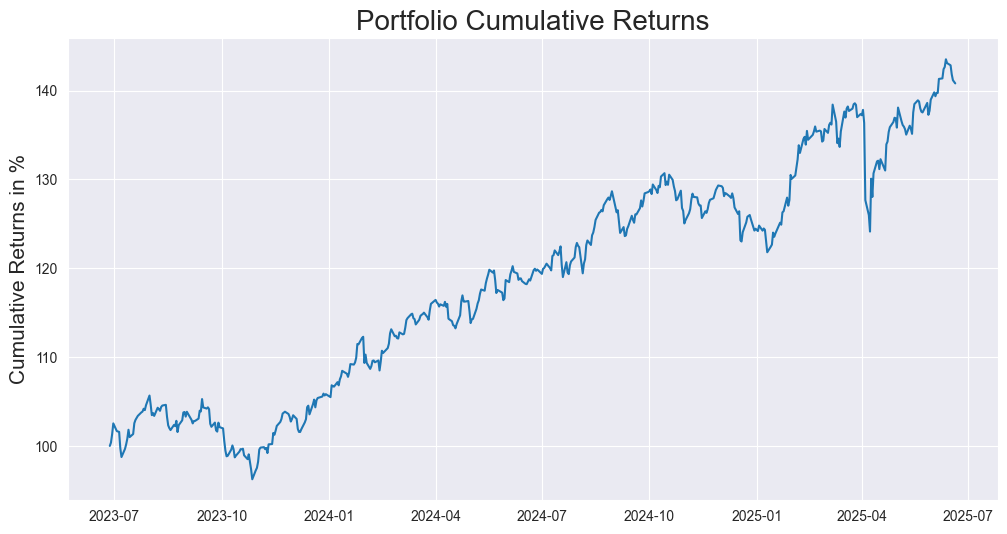

In [21]:
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize = (12,6))

plt.plot(daily_returns.index, cumulative_returns*100)
plt.title('Portfolio Cumulative Returns', size = 20)
plt.ylabel('Cumulative Returns in %', fontsize = 15)

plt.show()

In [22]:
print(f"Portfolio Sharpe Ratio: {Sr:.4f}")
print('---------')
print(f"Portfolio Volatility: {np.sqrt(sigma_V_2)}")
print('-------')
print(f"Portfolio annualized Expected return: {100*mu_V:.4f}%")
print('-------')
print(f"Portfolio Return: {100*cumulative_returns[-1]:.4f}%")
print('-------')
print(f"Portfolio Value at risk: {VaR}%")

Portfolio Sharpe Ratio: 1.0491
---------
Portfolio Volatility: 0.12487599205529225
-------
Portfolio annualized Expected return: 18.1007%
-------
Portfolio Return: 140.8087%
-------
Portfolio Value at risk: -1.1173376634617915%


In [ ]:
An alternative way to computate an approximation of the smalest portfolio variance is by utilizing Monte Carlo methods. Below  

## Part 2b: Portfolio optimization under the criteria of maximizing the portfolio risk adjustment performance (Sharpe ratio)

Monte Carlo simulation will be performed for finding a portfolio in which is maximized the Sharpe ratio. We will calculate random sets of portfolio investment percentages (asset weights) $w_i$, $i \in 1,\cdots, N$, where $N = 8$, with  similar constrains from (part 2a).

For each set of assets weights $\mathbf{w}$, will be calculated the main metrics for the portfolio.

In [29]:
n_samples = 6000
nc = len(tickers)
W = np.zeros((n_samples, nc))
MU = np.zeros(n_samples)
SI = np.zeros(n_samples)
SR = np.zeros(n_samples)
VAR = np.zeros(n_samples)
for i in range(n_samples):
    w = np.random.uniform(low = 0, high = 0.35, size = nc)
    w = w/np.sum(w)
    W[i,:] = w
    MU[i] = portfolio_expected_return(weights = w, daily_returns=daily_returns, tickers=tickers)
    SI[i] = portfolio_variance(weights= w, covariance_matrix=covariance_matrix)
    SR[i] = sharpe_ratio(mu_v =  MU[i], sigma_v = np.sqrt(SI[i]), risk_free_rate = 0.05 )
    portfolio_returns = returns(daily_returns = daily_returns, tickers=tickers, weights=w)
    VAR[i] = calculate_var_95(portfolio_returns)

First we generate an approximation of the minimum of the portfolio variance (Item 2a) via Monte Carlo simulation to compare with the previous results:

In [30]:
ind = SI.argmin()
print(f"Portfolio Sharpe Ratio: {SR[ind]:.4f}")
print('---------')
print(f"Portfolio Volatility: {np.sqrt(SI[ind])}")
print('-------')
print(f"Portfolio annualized Expected return: {100*MU[ind]:.4f}%")
print('-------')
print(f"Portfolio Value at risk: {VAR[ind]}%")

Portfolio Sharpe Ratio: 1.0357
---------
Portfolio Volatility: 0.12560954075459568
-------
Portfolio annualized Expected return: 18.0091%
-------
Portfolio Value at risk: -1.1563160253230464%


Now we estimate the maximum value of the Sharpe ratio for the portfolio.

In [31]:
ind = SR.argmax()
print(f"Portfolio Sharpe Ratio: {SR[ind]:.4f}")
print('---------')
print(f"Portfolio Volatility: {np.sqrt(SI[ind])}")
print('-------')
print(f"Portfolio annualized Expected return: {100*MU[ind]:.4f}%")
print('-------')
print(f"Portfolio Value at risk: {VAR[ind]}%")

Portfolio Sharpe Ratio: 2.1444
---------
Portfolio Volatility: 0.17144296285295652
-------
Portfolio annualized Expected return: 41.7645%
-------
Portfolio Value at risk: -1.4221064111985082%


Below we proceed to show the visualization of the expected return $\mu_V$ and the volatility $\sigma_V$ for the portfolio. The black dot corresponds to the values that maximize the Sharpe ratio. The green point corresponds to the values that minimize the variance (2a). 

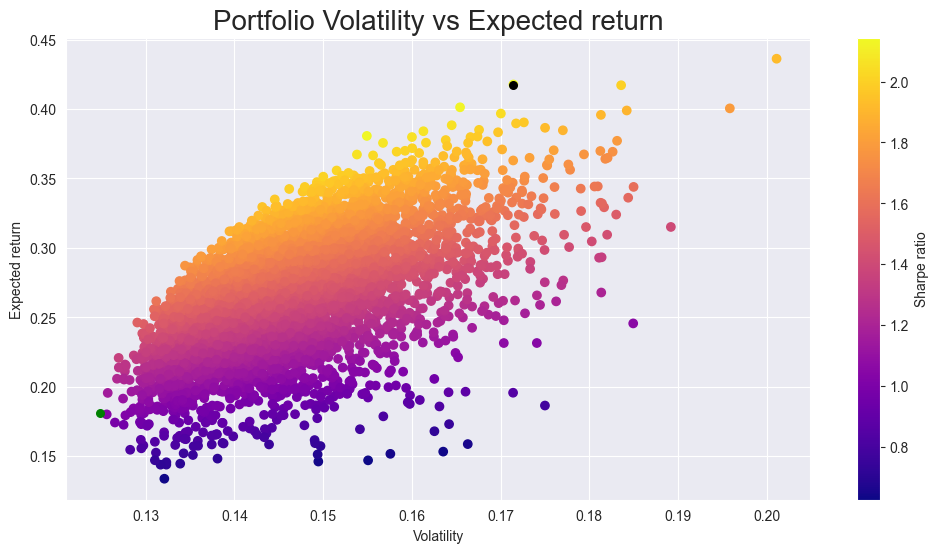

In [32]:
plt.figure(figsize= (12,6))
plt.scatter(np.sqrt(SI), MU, c = SR, cmap = 'plasma')
plt.colorbar(label = "Sharpe ratio")
plt.xlabel("Volatility")
plt.ylabel("Expected return")
plt.title('Portfolio Volatility vs Expected return', size = 20)
plt.scatter(np.sqrt(SI[ind]), MU[ind], c = "black", s=30)
plt.scatter(np.sqrt(sigma_V_2), mu_V, c = "green", s=30)


## Results

We selected eight companies from diverse sectors that did not exhibit strong correlations. 


(LOWER RISK) The portfolio with the lower risk was calculated by using the criteria of the minimum variance. The assets allocations for the case are 

In [33]:
for k in range(nc):
    print(f'{optimal_weights[k]*100 :.4f}% for {names_companies[k]}')

5.1259% for Fast Retailing Co., Ltd.
9.9261% for Alphabet Inc.
6.7787% for International Business Machines Corporation
5.3172% for JPMorgan Chase & Co.
5.1311% for Netflix, Inc.
29.9734% for Novartis AG
15.1363% for Exxon Mobil Corporation
22.6113% for Yum! Brands, Inc.


This portfolio has a volatility of 12.48%, an expected return of 18.10%, a risk adjustment performance of 1.05.

(HIGHER RISK) The portfolio with higher risk was calculated by using the criteria of the maximum Sharpe ratio. The assets allocations for the case are

In [34]:
optimal_weights2 = W[ind,:]
for k in range(nc):
    print(f'{optimal_weights2[k]*100 :.4f}% for {names_companies[k]}')

1.4463% for Fast Retailing Co., Ltd.
1.0687% for Alphabet Inc.
28.2643% for International Business Machines Corporation
24.8470% for JPMorgan Chase & Co.
29.1476% for Netflix, Inc.
0.5566% for Novartis AG
2.9703% for Exxon Mobil Corporation
11.6992% for Yum! Brands, Inc.


This portfolio has a volatility of 17.14%, an expected return of 41.76%, a risk adjustment performance of 2.14.

We observed that the point in which the volatility has the lowest value (green dot) is located at the lowest x-axis coordinate of the Monte Carlo simulated points. Also notice that the Sharpe ratio that has the maximum value (black dot) is located at the tangencial line above the Monte Carlo simulated points. The previous observations show the expected behaviour stated by the theory [1].

[1] Capiński, M., & Zastawniak, T. (2014). Mathematics for finance: An introduction to financial engineering. Springer. 